In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

import neurolib.dashboard.data as data
from neurolib.models.aln import ALNModel
import neurolib.dashboard.layout as layout
import neurolib.dashboard.functions as functions


# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [2]:
cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

rgb_cm = cmap.colors
print(rgb_cm[3][0]*255, rgb_cm[3][1]*255, rgb_cm[3][2]*255)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

facecolor_ = '#EAEAEA'
facecolor_ = 'white'

214.0 39.0 40.0


In [3]:
readpath = os.getcwd()

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

grid_resolution = layout.grid_resolution

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

In [4]:
##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
def read_file(file):
    
    with open(file,'rb') as file:
        load_array = pickle.load(file)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    costnode_ = load_array[6]
        
    return [bestControl_, bestState_, costnode_]
    

In [5]:
ind0 = 20
readpath = '..' + os.sep + 'data_final'
dur = 400.

opt_cntrl_taum2, opt_state_taum2, cost_node_taum2 = read_file(os.getcwd() + os.sep + 'metabotropic' + os.sep + 'control_00061.pickle')

data.set_parameters(aln)
aln.params.gL = 10.

aln.params.ext_exc_current = ext_exc[ind0] * 5.
aln.params.ext_inh_current = ext_inh[ind0] * 5.

print(ext_exc[ind0], ext_inh[ind0])
        
maxI = 10.          
aln.params.duration = 3000.
control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = maxI)
aln.run(control=control0)

aln.params.duration = dur
target_1 = aln.getZeroTarget()
target_1[:,0,:] = aln.rates_exc[0,-1] 
target_1[:,1,:] = aln.rates_inh[0,-1]

aln.params.duration = 3000.
control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = -maxI)
aln.run(control=control0)

initVars_1 = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        initVars_1[j] = aln.state[state_vars[j]][0]
    else:
        initVars_1[j] = aln.state[state_vars[j]][0,-1]
        
aln.params.duration = dur

0.4500000000000001 0.4750000000000002


In [6]:
def setinit(model, initial_params_):
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        if (type(model.params[init_vars[iv]]) == np.float64 or type(model.params[init_vars[iv]]) == float):
            model.params[init_vars[iv]] = initial_params_[iv]
        elif model.params[init_vars[iv]].ndim == 2:
            model.params[init_vars[iv]][0,:] = initial_params_[iv]
        else:
            model.params[init_vars[iv]][0] = initial_params_[iv]

def plot_control_current(model, control, t_sim_, initial_params, index,
                         target, path_, filename_ = '', transition_time_ = 0.):
    
    dt = model.params.dt
    control_factor = model.params.C/1000.
    fontsize_ = 18
        
    model.params.duration = (control.shape[2] - 1.) * dt
    output_vars = model.output_vars
    
    fig, ax = plt.subplots(2, figsize=(5, 5), constrained_layout=True)
    data.set_parameters(model)

    model.params.ext_exc_current = ext_exc[index] * 5.
    model.params.ext_inh_current = ext_inh[index] * 5.

    model.run(control=model.getZeroControl())

    ax[0].plot(model.t[:], target[0,0,:], '--', linewidth = 3, color=exc_red)
    ax[0].plot(model.t[:], target[0,1,:], '--', linewidth = 3, color=inh_blue)

    linewidth_ = 2.

    setinit(model, initial_params)
    model.run(control=control)

    ax[0].plot(model.t, model[output_vars[0]][0,:], linewidth=linewidth_, color=exc_red)
    ax[0].plot(model.t, model[output_vars[1]][0,:], linewidth=linewidth_, color=inh_blue)
    ax[1].plot(model.t, control[0,0,:] * control_factor, linewidth=linewidth_, color=exc_red, label='E')
    ax[1].plot(model.t, control[0,1,:] * control_factor, linewidth=linewidth_, color=inh_blue, label='I')
    # divide by five to take into account capacitance

    #####################
    ax[0].axvspan(transition_time_ * t_sim_, t_sim_, facecolor='grey', alpha=0.2
                    , zorder=-1, hatch='///', edgecolor = 'grey')

    max_current = np.amax(control)
    min_current = np.amin(control)

    y_lims = [1.1 * min_current * control_factor, 1.1 * max_current * control_factor]
    y_lims = [-0.65, 0.35]

    ylim_rates = [-10., 120.]
    
    ax[0].set_xlim(0.,t_sim_)
    ax[1].set_xlim(0.,t_sim_)
    ax[0].set_ylim(ylim_rates)
    ax[1].set_ylim(y_lims)

    ax[0].set_ylabel('Rate [Hz]', fontsize=fontsize_)      
    ax[1].set_ylabel('Control [nA]', fontsize=fontsize_) 
    ax[1].legend(fontsize=fontsize_)
        
    plt.savefig(os.path.join(path_, filename_), bbox_inches='tight', facecolor=fig.get_facecolor(),
                edgecolor='none', dpi=300)

In [34]:
def fig_fullstate(fullstate, path_, filename_):
    time = np.arange(0,400.1,0.1)
    fig, ax = plt.subplots(5, 2, figsize=(15,10))

    ax[0,0].plot(time, fullstate[2,:], label='mu_e', color=exc_red)
    ax[0,1].plot(time, fullstate[3,:], label='mu_i', color=inh_blue)
    ax[1,0].plot(time, fullstate[5,:], label='see', color=exc_red)
    ax[1,0].plot(time, fullstate[7,:], label='sie', color=inh_blue)
    ax[1,1].plot(time, fullstate[6,:], label='sei', color=exc_red)
    ax[1,1].plot(time, fullstate[8,:], label='sii', color=inh_blue)
    ax[2,0].plot(time, fullstate[9,:], label='sigma_ee', color=exc_red)
    ax[2,0].plot(time, fullstate[11,:], label='sigma_ie', color=inh_blue)
    ax[2,1].plot(time, fullstate[10,:], label='sigma_ei', color=exc_red)
    ax[2,1].plot(time, fullstate[12,:], label='sigma_ii', color=inh_blue)

    ax[3,0].plot(time, fullstate[15,:], label='sigma_e', color=exc_red)
    ax[3,1].plot(time, fullstate[16,:], label='sigma_i', color=inh_blue)
    ax[4,0].plot(time, fullstate[18,:], label='tau_e', color=exc_red)
    ax[4,1].plot(time, fullstate[19,:], label='tau_i', color=inh_blue)

    for j1 in range(5):
            ax[j1,0].legend()
            ax[j1,1].legend()

    plt.savefig(os.path.join(path_, filename_), bbox_inches='tight', facecolor=fig.get_facecolor(),
                edgecolor='none', dpi=300)
    
def getfullstate():
    state_vars = aln.state_vars
    fullstate = np.zeros(( 20,4001 ))
    for j in range(20):
        fullstate[j,:] = aln.state[state_vars[j]]
    return fullstate

0.4500000000000001 0.4750000000000002


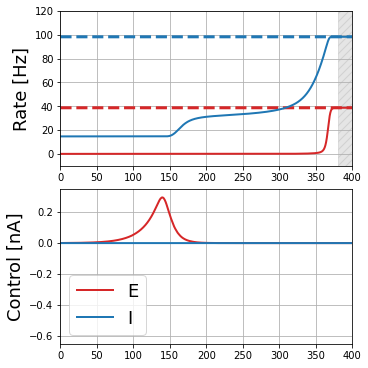

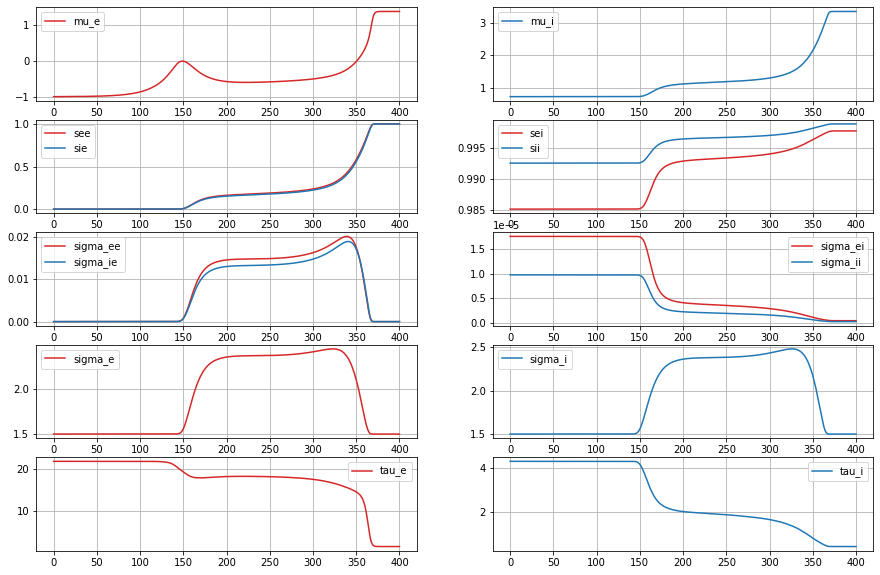

In [41]:
ind0 = 20
readpath = '..' + os.sep + 'data_final'
dur = 400.
label = 'metabotropic'

opt_cntrl_taum2, opt_state_taum2, cost_node_taum2 = read_file(os.getcwd() + os.sep + label + os.sep + 'control_00061.pickle')

data.set_parameters(aln)
aln.params.tau_se = 600.
aln.params.tau_si = 150.

aln.params.ext_exc_current = ext_exc[ind0] * 5.
aln.params.ext_inh_current = ext_inh[ind0] * 5.

print(ext_exc[ind0], ext_inh[ind0])
        
maxI = 3.          
aln.params.duration = 30000.
control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = maxI)
aln.run(control=control0)

#plt.plot(aln.t, aln.rates_exc[0,:])
#plt.show()

aln.params.duration = dur
target_1 = aln.getZeroTarget()
target_1[:,0,:] = aln.rates_exc[0,-1] 
target_1[:,1,:] = aln.rates_inh[0,-1]

aln.params.duration = 30000.
control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = -maxI)
aln.run(control=control0)

initVars_1 = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        initVars_1[j] = aln.state[state_vars[j]][0]
    else:
        initVars_1[j] = aln.state[state_vars[j]][0,-1]
        
aln.params.duration = dur

plot_control_current(aln, opt_cntrl_taum2[20][:,:,100:-100], dur, initVars_1, ind0,
                         target_1, os.getcwd(), filename_ = label + '_' + str(ind0) + '.png', transition_time_ = 0.95)
plt.show()


fullstate = getfullstate()
fig_fullstate(fullstate, os.getcwd(), filename_ = label + '_' + str(ind0) + '_fullstate.png')

0.47500000000000014 0.6000000000000003


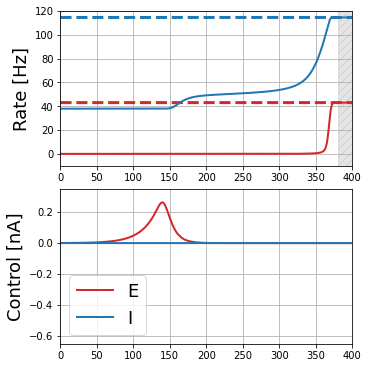

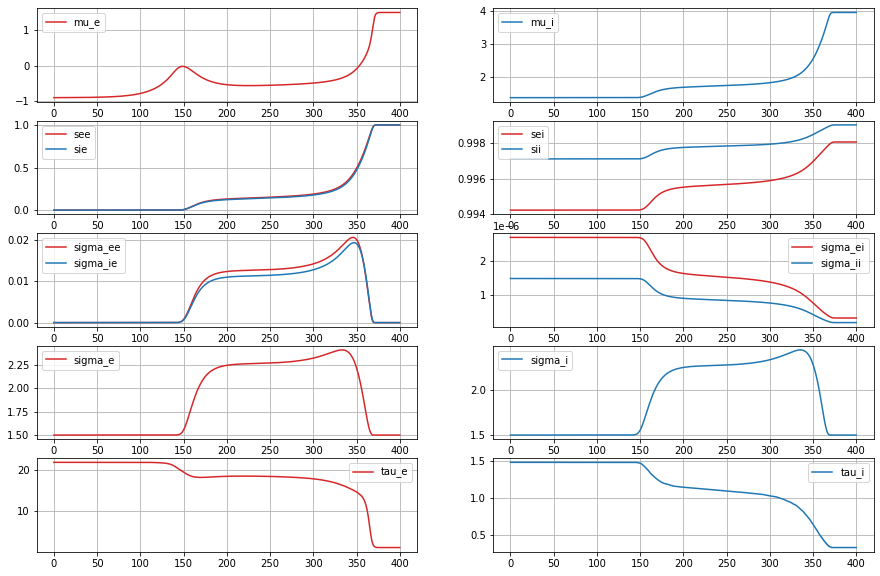

In [42]:
ind0 = 50
dur = 400.
#dur = 10000

opt_cntrl_taum2, opt_state_taum2, cost_node_taum2 = read_file(os.getcwd() + os.sep + label + os.sep + 'control_00061.pickle')

data.set_parameters(aln)

aln.params.ext_exc_current = ext_exc[ind0] * 5.
aln.params.ext_inh_current = ext_inh[ind0] * 5.

print(ext_exc[ind0], ext_inh[ind0])
        
maxI = 3.          
aln.params.duration = 30000.
control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = maxI)
aln.run(control=control0)


aln.params.duration = dur
target_1 = aln.getZeroTarget()
target_1[:,0,:] = aln.rates_exc[0,-1] 
target_1[:,1,:] = aln.rates_inh[0,-1]

aln.params.duration = 30000.
control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = -maxI)
aln.run(control=control0)

initVars_1 = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        initVars_1[j] = aln.state[state_vars[j]][0]
    else:
        initVars_1[j] = aln.state[state_vars[j]][0,-1]
        
aln.params.duration = dur

control1 = aln.getZeroControl()
control1[0,:,:4001] = (1.) * opt_cntrl_taum2[ind0][:,:,100:-100]

plot_control_current(aln, control1, dur, initVars_1, ind0,
                         target_1, os.getcwd(), filename_ = label + '_' + str(ind0) + '.png', transition_time_ = 0.95)
plt.show()

fullstate = getfullstate()
fig_fullstate(fullstate, os.getcwd(), filename_ = label + '_' + str(ind0) + '_fullstate.png')